Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# %matplotlib inline
plt.style.use("ggplot")

import sklearn
from sklearn.decomposition import TruncatedSVD

In [2]:
data = pd.read_csv('ratings_Beauty.csv')

In [3]:
data.head()

,UserId,ProductId,Rating,Timestamp
0,A39HTATAQ9V7YF,0205616461,5.0,1369699200
1,A3JM6GV9MNOF9X,0558925278,3.0,1355443200
2,A1Z513UWSAAO0F,0558925278,5.0,1404691200
3,A1WMRR494NWEWV,0733001998,4.0,1382572800
4,A3IAAVS479H7M7,0737104473,1.0,1274227200


In [4]:
data.shape

(2023070, 4)

In [5]:
data.isnull().sum() 

UserId       0
ProductId    0
Rating       0
Timestamp    0
dtype: int64

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2023070 entries, 0 to 2023069
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   UserId     object 
 1   ProductId  object 
 2   Rating     float64
 3   Timestamp  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 61.7+ MB


In [7]:
data.describe()

,Rating,Timestamp
count,2.023070e+06,2.023070e+06
mean,4.149036e+00,1.360389e+09
std,1.311505e+00,4.611860e+07
min,1.000000e+00,9.087552e+08
25%,4.000000e+00,1.350259e+09
50%,5.000000e+00,1.372810e+09
75%,5.000000e+00,1.391472e+09
max,5.000000e+00,1.406074e+09


<Axes: xlabel='Rating', ylabel='count'>

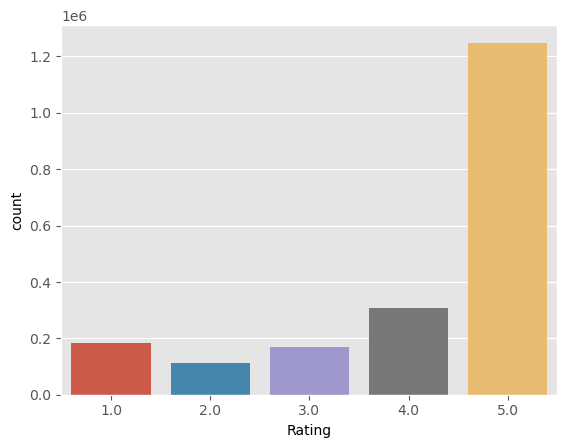

In [10]:
import seaborn as sns
sns.countplot(x='Rating',data=data) #count number of every rating graphically

In [9]:
data.groupby('Rating')['UserId'].count() #How many user give each rating

Rating
1.0     183784
2.0     113034
3.0     169791
4.0     307740
5.0    1248721
Name: UserId, dtype: int64

In [10]:
#create a dataframe with average rating in one column
rating= pd.DataFrame(data.groupby('ProductId')['Rating'].mean().sort_values(ascending=False))

#create another column with number of rating given to that product
rating['number of rating'] = pd.DataFrame(data.groupby('ProductId')['Rating'].count().sort_values(ascending=False))
rating.sort_values('number of rating',ascending=False)

,Rating,number of rating
ProductId,,
B001MA0QY2,4.321386,7533
B0009V1YR8,3.568839,2869
B0043OYFKU,4.310456,2477
B0000YUXI0,4.405040,2143
B003V265QW,4.365421,2088
...,...,...
B0013H228W,5.000000,1
B0013GNAIE,5.000000,1
B0013GNAG6,5.000000,1


<Axes: xlabel='ProductId'>

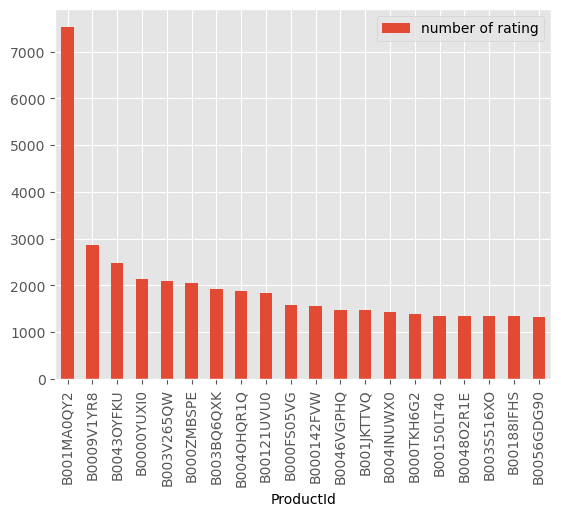

In [11]:
#Top 20 products sell by ecommerce website shown graphically

rating[['number of rating']].sort_values('number of rating',ascending=False).head(20).plot(kind='bar')

Analysis:

- The above graph gives us the most popular products (arranged in descending order) sold by the business.

- For eaxmple, product, ID # B001MA0QY2 has sales of over 7000, the next most popular product, ID # B0009V1YR8 has sales of 3000, etc.

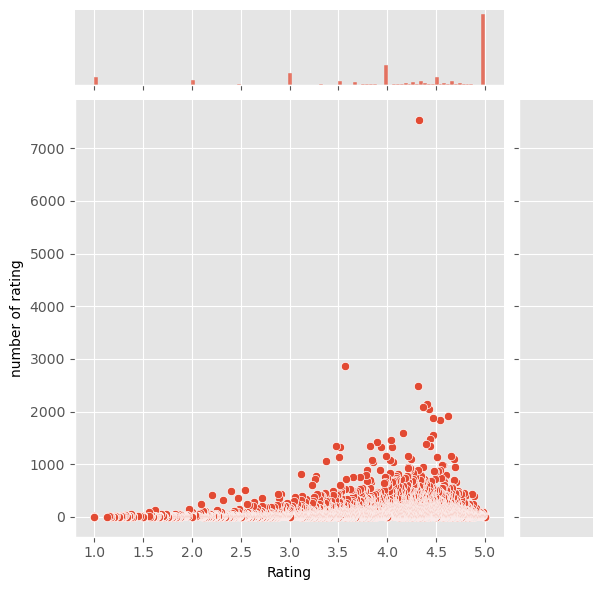

In [12]:
#This graph doesn't add much insight but we can figure out that most of the 5 rating given by very few users. 
sns.jointplot(x='Rating',y='number of rating',data=rating)

In [ ]:
Time-based Analysis:

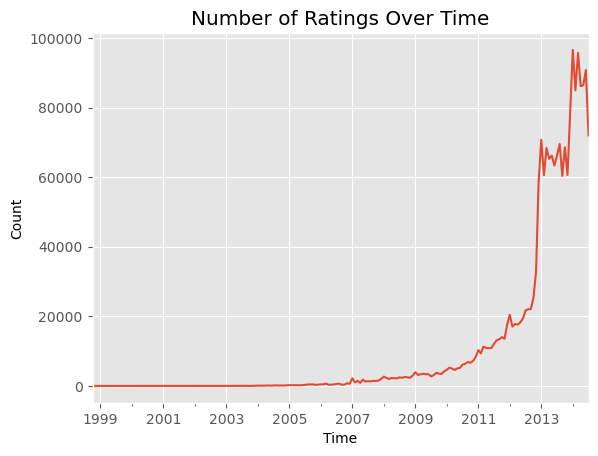

In [29]:
# Convert timestamp to datetime
data['Datetime'] = pd.to_datetime(data['Timestamp'], unit='s')

# Plot the number of ratings over time
data.set_index('Datetime').resample('M')['Rating'].count().plot()
plt.title('Number of Ratings Over Time')
plt.xlabel('Time')
plt.ylabel('Count')
plt.show()


In [30]:
# Display the number of unique users and products
num_users = data['UserId'].nunique()
num_products = data['ProductId'].nunique()
print(f"Number of unique users: {num_users}")
print(f"Number of unique products: {num_products}")


Number of unique users: 1210271
Number of unique products: 249274


C:\Users\ASUS\AppData\Local\Temp\ipykernel_9648\3492086043.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = data.corr()


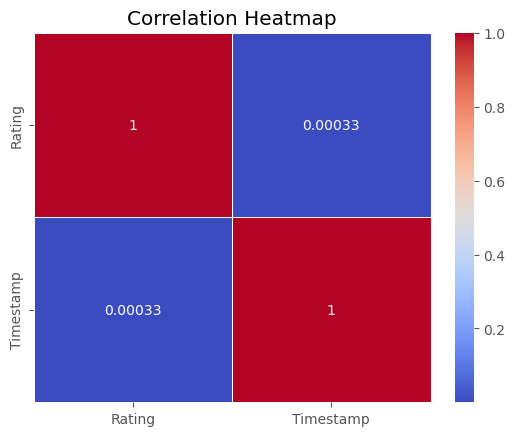

In [31]:
# Display a correlation heatmap
import seaborn as sns

corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


# Model-based collaborative filtering system

We will use Collaborative Filtering approach to recommend items to user.
We will Recommend items to user based on purchase history and similarity of ratings provided by other users who bought items same as that particular customer.

Recommend items to users based on purchase history and similarity of ratings provided by other users who bought items to that of a particular customer.
A model based collaborative filtering technique is closen here as it helps in making predictinfg products for a particular user by identifying patterns based on preferences from multiple user data.
Utility Matrix based on products sold and user reviews
Utility Matrix : An utlity matrix is consists of all possible user-item preferences (ratings) details represented as a matrix. The utility matrix is sparce as none of the users would buy all teh items in the list, hence, most of the values are unknown.

In [8]:
#As data is huge so we take a fraction of the data so that we can create a user item matrix. 

data1 = data.head(10000)
ratings_utility_matrix = data1.pivot_table(values='Rating', index='UserId', columns='ProductId')
ratings_utility_matrix.head()

ProductId,0205616461,0558925278,0733001998,0737104473,0762451459,1304139212,1304139220,130414089X,130414643X,1304146537,...,B000052YPE,B000052YPF,B000052YPG,B000052YPH,B000052YPM,B000052YPU,B000052YPV,B000052YPY,B000052YQ0,B000052YQ2
UserId,,,,,,,,,,,,,,,,,,,,,
A00205921JHJK5X9LNP42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A024581134CV80ZBLIZTZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A03056581JJIOL5FSKJY7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A03099101ZRK4K607JVHH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A0505229A7NSH3FRXRR4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
ratings_utility_matrix.shape

(9697, 886)

This matrix is consists of all possible user-item preferences (ratings) details represented as a matrix.

As you can see, Most of the values in utility matrix is not filled, which is expected because every user can not give rating to all products. That's why fill NaN values with 0.

In [12]:
ratings_utility_matrix.fillna(0, inplace=True)

In [13]:
# Transpose the matrix
X = ratings_utility_matrix.T

In [14]:
X.head()

UserId,A00205921JHJK5X9LNP42,A024581134CV80ZBLIZTZ,A03056581JJIOL5FSKJY7,A03099101ZRK4K607JVHH,A0505229A7NSH3FRXRR4,A05492663T95KW63BR75K,A059547920Q3LZVFHLPI3,A07410232KYRFR25CIUGJ,A082796624UNM47DSAI6K,A0864963DOAY7LXGS5I6,...,AZW1HXXYAC15B,AZWRTJPN7NXT,AZWTXHXZXFAYP,AZYQEFB9Y5N22,AZZHB6U54UDYW,AZZHJZP4GQPPZ,AZZNK89PXD006,AZZOFVMQC0BJG,AZZQXL8VDCFTV,AZZTJQ7CQZUD8
ProductId,,,,,,,,,,,,,,,,,,,,,
0205616461,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0558925278,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0733001998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0737104473,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0762451459,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
X.shape

(886, 9697)

Decomposing the matrix using TruncatedSVD, It is a dimensionality reduction technique.

In [18]:
from sklearn.decomposition import TruncatedSVD

In [19]:
SVD = TruncatedSVD(n_components=10) #n_component is desired dimension of output data
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix

array([[ 3.50677460e-16,  6.22279916e-14, -8.90079046e-15, ...,
        -9.71664352e-14,  8.98307516e-14, -5.03822555e-12],
       [ 8.54867672e-15,  1.27649605e-13, -3.21108227e-13, ...,
         5.66177198e-13,  5.12344695e-13,  4.91930862e-11],
       [ 3.43179691e-16,  3.93980737e-16, -7.05757507e-16, ...,
        -3.35577053e-14, -1.35507738e-15,  1.04038902e-14],
       ...,
       [ 3.95361669e-06,  2.27952602e-01, -1.04116769e-02, ...,
        -3.84118050e-03,  2.28232924e-04, -4.82465062e-02],
       [ 1.79141310e-06,  7.96666950e-04, -3.77892689e-05, ...,
        -7.95634427e-05,  2.05132444e-04,  8.61508966e-04],
       [ 5.82595303e-04,  4.16461195e-01,  3.56734535e-01, ...,
        -9.80587811e-02,  1.25266415e-01,  1.20326847e+00]])

In [20]:
decomposed_matrix.shape

(886, 10)

In [21]:
#corrcoef() returns the correlation matrix with correlation coefficient in it. 

correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix

array([[ 1.        , -0.99853987, -0.21091301, ...,  0.31876382,
        -0.13670279, -0.65678261],
       [-0.99853987,  1.        ,  0.19019964, ..., -0.30958705,
         0.11779158,  0.65156513],
       [-0.21091301,  0.19019964,  1.        , ..., -0.01736674,
         0.8419122 ,  0.6515068 ],
       ...,
       [ 0.31876382, -0.30958705, -0.01736674, ...,  1.        ,
         0.05005062, -0.11429257],
       [-0.13670279,  0.11779158,  0.8419122 , ...,  0.05005062,
         1.        ,  0.70559321],
       [-0.65678261,  0.65156513,  0.6515068 , ..., -0.11429257,
         0.70559321,  1.        ]])

In [22]:
correlation_matrix.shape

(886, 886)

In [23]:
#choose a random index
import random
i = random.randint(0,correlation_matrix.shape[0])
i

493

In [24]:
#The Product ID of the product the customer purchased
product_ID = X.index[i]
product_ID

'9790789890'

In [25]:
#All the correlation of those products which are correlated to the product that customer purchase
correlation_ProductId = correlation_matrix[i]

correlation_ProductId

array([ 0.99091955, -0.98947808, -0.30561197, -0.98827473, -0.99298395,
        0.99764021,  0.98878844, -0.7350955 ,  0.99764574, -0.97523333,
        0.98878844, -0.97400002,  0.98844843,  0.99686152,  0.99764021,
        0.98878844,  0.98878844,  0.98396067,  0.98844844, -0.99809066,
       -0.95997623, -0.99140664,  0.98759064, -0.97376322, -0.96162436,
        0.92151362,  0.91675283,  0.99387656, -0.97376322,  0.92758768,
        0.93116533,  0.99763323,  0.98011488,  0.92176646, -0.97396292,
        0.99764021,  0.92176646, -0.97627843,  0.99765011,  0.99405351,
        0.99404745,  0.92151362,  0.99763543,  0.99764021,  0.99764021,
        0.99764021, -0.97376322,  0.99764021,  0.99764461,  0.99405351,
       -0.98153517, -0.95753529, -0.98988746,  0.98216241,  0.31341995,
       -0.96328993, -0.96176227,  0.43924995, -0.9405579 ,  0.80914246,
        0.73741768, -0.97121549, -0.9162497 ,  0.99361786, -0.91751012,
       -0.95241754, -0.87539118,  0.95528546, -0.99221132,  0.87

In [26]:
#Top products to be displayed by the recommendation system to the above customer based on the purchase history of other cutomers on website
recommended_products = X.index[correlation_ProductId > 0.90] 
recommended_products = list(recommended_products)

#Top 10 Products recommended to the user based on the purchase done by user
recommended_products[0:10]

['0205616461',
 '1304139212',
 '1304139220',
 '130414643X',
 '130414674X',
 '1304174778',
 '1304174867',
 '1304174905',
 '1304196046',
 '1304196062']